In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from genetic import GeneticPrograming 

np.random.seed(seed=21)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction
The idea of this notebook is to use genetic programming to create weak learners used in a GBM.

Here is the wiki explanation about genetic programming
https://en.wikipedia.org/wiki/Genetic_programming

But in a few lines we can explain as:

* The model is a tree structure which is evolved through time.

* The nodes are functions and the terminal nodes (leaves) can be constants or variables.

* The evolution process is carried out with mutation and crossover of the individuals in a population.

The algorithm inspiration is the genetic evolution from where the name is based (genetic programming).

I hid the code below to keep the notebook more clean

# Example 1 - Sine
First we will test the code to approximate a sine function

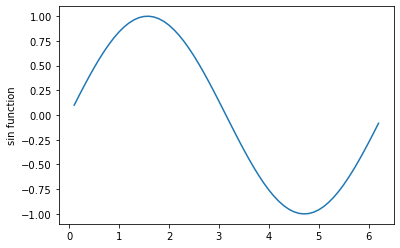

In [2]:
x1 = np.arange(0.1,np.pi*2,0.1)
y1 = np.sin(x1)

# plot best solutio

plt.plot(x1,y1)
plt.ylabel('sin function')

plt.show()

# Parameters

We need to set the <b>functions, constants and variables</b> parameters which will be used during the evolution process and the control parameters  <b>deep of the tree structure</b>, deep allowed for the tree to grow, <b> the number of individuals, </b> that will be evolved, and the  <b>number of generations </b> set to the algorithm run.

First we define the functions <b>(func)</b>,constants<b>(c)</b> and variavles<b>(v)</b>

In [3]:
#functions
func = [np.add, np.subtract, np.multiply]#, np.hypot, np.arctan2, np.logaddexp,np.minimum,np.maximum]
# variables - normalize between 0 e 1 (to imporve convergence time)
x1 = x1/(2*np.pi)
v = [x1]
c=[-2,-0.5,-0.1,0.1,0.5,2]

Then the control parameters maxDeep <b>10</b>, number of individuals <b>60</b> and number of generations <b>1000</b>

In [4]:
maxDeep = 10
n_individuals = 60
generations = 1000

gclass = GeneticPrograming(2, maxDeep,v,func,c,y1)
gclass.run(n_individuals,generations)

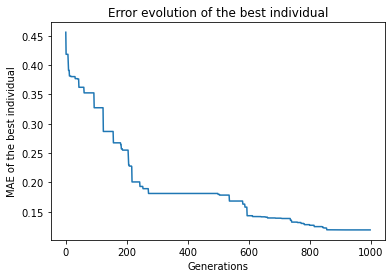

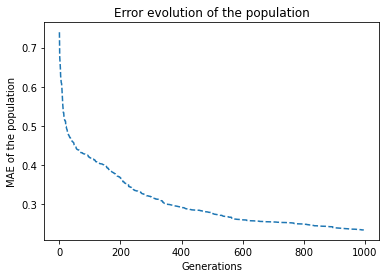

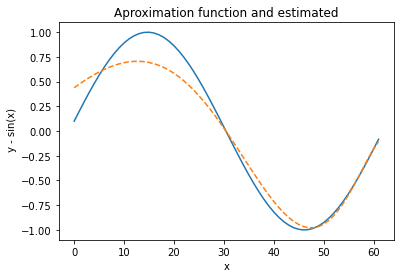

In [5]:
plt.plot(gclass.best[3:])
plt.title('Error evolution of the best individual')
plt.ylabel('MAE of the best individual')
plt.xlabel('Generations')
plt.show()
plt.plot(gclass.pop[3:],'--')
plt.title('Error evolution of the population')
plt.ylabel('MAE of the population')
plt.xlabel('Generations')

plt.show()


# plot best solutio
best = np.argsort(gclass.solEval)[0]
y_hat = gclass.evaluateTree(gclass.candidates[best])
plt.plot(y1)
plt.title('Aproximation function and estimated')
plt.ylabel(' y - sin(x)')
plt.xlabel('x')
plt.plot(y_hat,'--')
plt.show()

In the figures above it is possible to see the evolution of the best individual, figure 1, (which has some steps during the generations) and the evolution of the population, figure 2, which tends to go in the direction of the best individual due the evolution pressure (expressed in the fitness function, in this case MAE) in the genetic algorithm . The figure 3 has the fitted function in orange lines and the original sine function in blue.

The crossover between individuals will keep the best "genes", here sections of the tree model, passing at each epoch. And the mutation factor will incorpore new "genes" in the population to keep diversity.

Other possible visualization is the model structure, a matrix which encodes all necessary information to calculate the fitted function.

In [6]:
gclass.candidates[best] # this is the matrix wich represents the best fitted individual

array([[  2,   2,   2,   1, 390],
       [  0,   2,   2,   1,   2],
       [  2,   1,   0,   0,   5],
       ...,
       [  0,   0,   1,   4,   0],
       [  2,   0,   2,   5,   1],
       [  1,   0,   1,   4,   0]])

#  Competiton data
Now let`s test it on the competition data

Preprocessing the inputs

In [7]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d')
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.day_of_week
train_df['day_of_year'] = train_df['date'].dt.day_of_year

test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.day_of_week
test_df['day_of_year'] = test_df['date'].dt.day_of_year


Normalization of the output 
(there is a huge modification in the data regime that we have to deal with it).

<AxesSubplot:xlabel='year', ylabel='num_sold'>

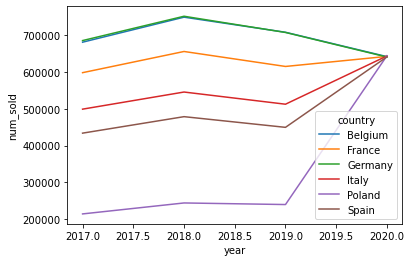

In [8]:
yy = train_df[['year','country','num_sold']].groupby(['year','country']).sum().reset_index().sort_values(by=['country','year'])
sns.lineplot(data=yy, x="year", y="num_sold", hue="country")

In [9]:
qtO = QuantileTransformer(n_quantiles=100, random_state=0,output_distribution='normal')
qtO.fit(train_df.num_sold.loc[(train_df.year == 2020) & (train_df.store == 'KaggleMart') ].values.reshape(-1, 1))
        
qtO2 = QuantileTransformer(n_quantiles=100, random_state=0,output_distribution='normal')
qtO2.fit(train_df.num_sold.loc[(train_df.year == 2020) & (train_df.store == 'KaggleRama') ].values.reshape(-1, 1))

for country in train_df.country.unique():
    
    qt = QuantileTransformer(n_quantiles=100, random_state=0,output_distribution='normal')
    y_mod = qt.fit_transform(train_df.num_sold.loc[ (train_df.year < 2020) & (train_df.country == country)& (train_df.store == 'KaggleMart')].values.reshape(-1, 1))
    train_df.loc[(train_df.year < 2020) & (train_df.country == country) & (train_df.store == 'KaggleMart'),'num_sold'] = qtO.inverse_transform(y_mod)
    
    qt = QuantileTransformer(n_quantiles=100, random_state=0,output_distribution='normal')
    y_mod = qt.fit_transform(train_df.num_sold.loc[ (train_df.year < 2020) & (train_df.country == country)& (train_df.store == 'KaggleRama')].values.reshape(-1, 1))
    train_df.loc[(train_df.year < 2020) & (train_df.country == country) & (train_df.store == 'KaggleRama'),'num_sold'] = qtO2.inverse_transform(y_mod)

<AxesSubplot:xlabel='year', ylabel='num_sold'>

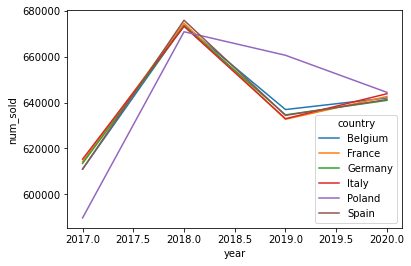

In [10]:
yy = train_df[['year','country','num_sold']].groupby(['year','country']).sum().reset_index().sort_values(by=['country','year'])
sns.lineplot(data=yy, x="year", y="num_sold", hue="country")

In [11]:
# function to optimize
def smape(y,y_hat):
    num = np.abs(y_hat-y)
    den = (np.abs(y)+np.abs(y_hat))/2
    return( (np.sum(num/den)/len(y))*100 ) 

# Splitting train and test

I tried to let all data between 0-1 to improve the speed of convergence

In [12]:
np.floor(np.arange(14)/7)

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
nomes =['day_of_year','day_of_week','day','month','store','product','country']

# I removed this data to avoid the problems in normalization in the data
train_df = train_df.loc[train_df.date != '2020-02-29' ]

train_df.loc[(train_df.day_of_year > 60) & (train_df.year == 2020),'day_of_year'] = train_df.day_of_year.loc[(train_df.day_of_year > 60) & (train_df.year == 2020)].values -1

train_df['c_day'] = np.floor(train_df['day']/7)/5
train_df['week'] = np.floor(train_df['day_of_year']/7)/53

train_df['day_of_year'] = (train_df['day_of_year'])/365
train_df['day_of_week'] = train_df['day_of_week']/6
train_df['day'] = train_df['day']/31
train_df['month'] = train_df['month']/12



col = 'store'
train_df[col] = train_df[col].astype("category").cat.codes
col = 'product'
train_df[col] = (train_df[col].astype("category").cat.codes)/5
col = 'country'
train_df[col] = train_df[col].astype("category").cat.codes/6

# test
test_df['c_day'] = (np.floor(test_df['day']/7))/5
test_df['week'] = (np.floor(test_df['day_of_year']/7))/53


test_df['day_of_year'] = (test_df['day_of_year'])/365
test_df['day_of_week'] = test_df['day_of_week']/6
test_df['day'] = test_df['day']/31
test_df['month'] = test_df['month']/12


col = 'store'
test_df[col] = test_df[col].astype("category").cat.codes
col = 'product'
test_df[col] = (test_df[col].astype("category").cat.codes)/5
col = 'country'
test_df[col] = test_df[col].astype("category").cat.codes/6



train_data = train_df.loc[ (train_df.year == 2019)]
test_data = train_df.loc[train_df.year == 2020]

In [14]:
count_day = train_data[['day_of_year','num_sold']].groupby('day_of_year').sum().reset_index()

# Features generation

In [15]:
count_day['std_d1'] = ((np.mean(count_day.num_sold)-1*np.std(count_day.num_sold))>count_day.num_sold)*1
count_day['std_u3'] =((np.mean(count_day.num_sold)+3*np.std(count_day.num_sold))<count_day.num_sold)*1

In [16]:
train_df =  train_df.loc[ (train_df.year == 2019) ]

a =train_df[['store','num_sold','week']].groupby(['store','week']).sum().reset_index()
b =train_df[['product','store','num_sold','week']].groupby(['week','product','store']).sum().reset_index()
c1 = pd.merge(a,b,left_on=['store','week'],right_on=['store','week'])
c1['r1']=c1['num_sold_y']/c1['num_sold_x']

a = train_df[['store','num_sold','day_of_year']].groupby(['store','day_of_year']).sum().reset_index()
b =train_df[['product','store','num_sold','day_of_year']].groupby(['day_of_year','product','store']).sum().reset_index()
c2 = pd.merge(a,b,left_on=['store','day_of_year'],right_on=['store','day_of_year'])
c2['r2']=c2['num_sold_y']/c2['num_sold_x']

train_data = pd.merge(train_data,c1[['product','store','week','r1']].drop_duplicates(),how='left', on=['product','store','week'])
test_data = pd.merge(test_data,c1[['product','store','week','r1']].drop_duplicates(),how='left', on=['product','store','week'])
test_df = pd.merge(test_df,c1[['product','store','week','r1']].drop_duplicates(),how='left', on=['product','store','week'])

train_data = pd.merge(train_data,c2[['product','store','day_of_year','r2']].drop_duplicates(),how='left', on=['product','store','day_of_year'])
test_data = pd.merge(test_data,c2[['product','store','day_of_year','r2']].drop_duplicates(),how='left', on=['product','store','day_of_year'])
test_df = pd.merge(test_df,c2[['product','store','day_of_year','r2']].drop_duplicates(),how='left', on=['product','store','day_of_year'])

h1 = train_df[['month','day_of_week','num_sold']].groupby(['day_of_week','month']).agg(['min','max','mean','median']).reset_index()
h2 = train_df[['month','product','num_sold']].groupby(['product','month']).agg(['min','max','mean','median']).reset_index()
h3 = train_df[['month','store','num_sold']].groupby(['store','month']).agg(['min','max','mean','median']).reset_index()


h1.columns = h1.columns.map('_A'.join).str.strip('_')
h2.columns = h2.columns.map('_B'.join).str.strip('_')
h3.columns = h3.columns.map('_C'.join).str.strip('_')

for nn_nome in ['num_sold_Cmax','num_sold_Cmin']:
    h3[nn_nome] = (h3[nn_nome] - h3[nn_nome].min())/ (h3[nn_nome].max() - h3[nn_nome].min())
    h3[nn_nome] = np.log(h3[nn_nome]+1)
    
for nn_nome in ['num_sold_Bmean']:
    h2[nn_nome] = (h2[nn_nome] - h2[nn_nome].min())/ (h2[nn_nome].max() - h2[nn_nome].min())
    h2[nn_nome] = np.log(h2[nn_nome]+1)
    
for nn_nome in ['num_sold_Amean']:
    h1[nn_nome] = (h1[nn_nome] - h1[nn_nome].min())/ (h1[nn_nome].max() - h1[nn_nome].min())
    h1[nn_nome] = np.log(h1[nn_nome]+1)


train_data = pd.merge(train_data,h1,how='left', left_on=['day_of_week','month'], right_on=['day_of_week_A','month_A'])
train_data.drop('day_of_week_A',axis = 1,inplace=True)
train_data.drop('month_A',axis = 1,inplace=True)

test_data = pd.merge(test_data,h1,how='left', left_on=['day_of_week','month'], right_on=['day_of_week_A','month_A'])
test_data.drop('day_of_week_A',axis = 1,inplace=True)
test_data.drop('month_A',axis = 1,inplace=True)

test_df = pd.merge(test_df,h1,how='left', left_on=['day_of_week','month'], right_on=['day_of_week_A','month_A'])
test_df.drop('day_of_week_A',axis = 1,inplace=True)
test_df.drop('month_A',axis = 1,inplace=True)


train_data = pd.merge(train_data,h2,how='left', left_on=['product','month'], right_on=['product_B','month_B'])
train_data.drop('month_B',axis = 1,inplace=True)
train_data.drop('product_B',axis = 1,inplace=True)

test_data = pd.merge(test_data,h2,how='left', left_on=['product','month'], right_on=['product_B','month_B'])
test_data.drop('month_B',axis = 1,inplace=True)
test_data.drop('product_B',axis = 1,inplace=True)

test_df = pd.merge(test_df,h2,how='left', left_on=['product','month'], right_on=['product_B','month_B'])
test_df.drop('month_B',axis = 1,inplace=True)
test_df.drop('product_B',axis = 1,inplace=True)

train_data = pd.merge(train_data,h3,how='left', left_on=['store','month'], right_on=['store_C','month_C'])
train_data.drop('month_C',axis = 1,inplace=True)
train_data.drop('store_C',axis = 1,inplace=True)

test_data = pd.merge(test_data,h3,how='left', left_on=['store','month'], right_on=['store_C','month_C'])
test_data.drop('month_C',axis = 1,inplace=True)
test_data.drop('store_C',axis = 1,inplace=True)

test_df = pd.merge(test_df,h3,how='left', left_on=['store','month'], right_on=['store_C','month_C'])
test_df.drop('month_C',axis = 1,inplace=True)
test_df.drop('store_C',axis = 1,inplace=True)

train_data['sin'] = np.sin(train_data.day_of_year*2*np.pi)
train_data['2sin'] = np.sin(train_data.day_of_year*4*np.pi)
train_data['sin1'] = np.sin(train_data.day_of_year*np.pi)
train_data['sin2'] = np.sin(train_data.day_of_year*0.5*np.pi)

test_data['sin'] = np.sin(test_data.day_of_year*2*np.pi)
test_data['2sin'] = np.sin(test_data.day_of_year*4*np.pi)
test_data['sin1'] = np.sin(test_data.day_of_year*np.pi)
test_data['sin2'] = np.sin(test_data.day_of_year*0.5*np.pi)

test_df['sin'] = np.sin(test_df.day_of_year*2*np.pi)
test_df['2sin'] = np.sin(test_df.day_of_year*4*np.pi)
test_df['sin1'] = np.sin(test_df.day_of_year*np.pi)
test_df['sin2'] = np.sin(test_df.day_of_year*0.5*np.pi)

#https://www.kaggle.com/code/hasanbasriakcay/tpssep22-insightful-eda-fe-gdp-covid19/notebook
# insight of cos52 and cos1

test_df['cos'] = np.cos(test_df.day_of_year*2*np.pi)
test_data['cos'] = np.cos(test_data.day_of_year*2*np.pi)
train_data['cos'] = np.cos(train_data.day_of_year*2*np.pi)



train_data = pd.merge(train_data,count_day[['day_of_year','std_d1','std_u3']],how='left', on=['day_of_year'])
test_data = pd.merge(test_data,count_day[['day_of_year','std_d1','std_u3']],how='left', on=['day_of_year'])
test_df = pd.merge(test_df,count_day[['day_of_year','std_d1','std_u3']],how='left', on=['day_of_year'])


The features that will be used are below. 

I got them from the importance of a LGBM trained model

In [17]:
nomes.append('r1')
nomes.append('r2')

nomes.append('num_sold_Cmax')
nomes.append('num_sold_Amean')
nomes.append('num_sold_Cmin')
nomes.append('num_sold_Bmean')

nomes.append('c_day')
nomes.append('week')

nomes.append('sin')
nomes.append('2sin')
nomes.append('sin2')
nomes.append('sin1')

nomes.append('cos')

In [18]:
# printing the training data frame
test_data[nomes].head()

,day_of_year,day_of_week,day,month,store,product,country,r1,r2,num_sold_Cmax,num_sold_Amean,num_sold_Cmin,num_sold_Bmean,c_day,week,sin,2sin,sin2,sin1,cos
0,0.00274,0.333333,0.032258,0.083333,0,0.0,0.0,0.284162,0.275910,0.520103,0.3224,0.693147,0.606839,0.0,0.0,0.017213,0.034422,0.004304,0.008607,0.999852
1,0.00274,0.333333,0.032258,0.083333,0,0.2,0.0,0.228433,0.236789,0.520103,0.3224,0.693147,0.365537,0.0,0.0,0.017213,0.034422,0.004304,0.008607,0.999852
2,0.00274,0.333333,0.032258,0.083333,0,0.4,0.0,0.189790,0.191717,0.520103,0.3224,0.693147,0.248501,0.0,0.0,0.017213,0.034422,0.004304,0.008607,0.999852
3,0.00274,0.333333,0.032258,0.083333,0,0.6,0.0,0.297615,0.295584,0.520103,0.3224,0.693147,0.612585,0.0,0.0,0.017213,0.034422,0.004304,0.008607,0.999852
4,0.00274,0.333333,0.032258,0.083333,1,0.0,0.0,0.284409,0.285204,0.041499,0.3224,0.141801,0.606839,0.0,0.0,0.017213,0.034422,0.004304,0.008607,0.999852


# Loop with GBM

Although GBMs are most used with tree models, we can use any weak learner to implement the algorithm, here we choose the GP optimizations to generate functions because the data has a high probability of coming from a math function, this increases the chances of a good fit.

In [19]:
import copy as copy

In [ ]:
mse_model = 1000
mse_model_val = 1000

#GP boosting

#0.1 # learning rate
LR = 0.1


# removing mean and scaling the output
mm = np.mean(train_data.num_sold.values)

yt = (train_data.num_sold.values - mm)
mmin = np.min(yt)
yt = yt-np.min(yt)
mmax = np.max(yt)
yt = yt/mmax
yt = np.log(yt+1)

orig_yt = copy.copy(yt)

yv = (test_data.num_sold.values - mm)
yv = (yv-mmin)/mmax

yv = yv=np.log(yv+1)
orig_yv = copy.copy(yv)

# available functions
func = [np.add, np.subtract, np.multiply,np.minimum,np.maximum]# np.hypot, np.arctan2, np.logaddexp,]

# create input vector
v = []
v_validation = []
y_test = []
# % validation

for var_nome in nomes:

    v.append(train_data [var_nome].values)   
    v_validation.append(test_data[var_nome].values)   
    y_test.append(test_df[var_nome].values)   
    
    
c=[-2,-0.5,-0.1,0.1,0.5,2,np.pi]
maxDeep = 3    

y_hat_reg = 0
y_hat_val = 0
y_predict = 0

train_evo = []
test_evo = []
# GBM loop

for n in range(500):
        
    gclass = GeneticPrograming(2, maxDeep,v,func,c,yt)
    gclass.run(50,1000)

    #get the best individual
    
    flag = 0
    # for trying the best 5 solutions in the current update
    order = np.argsort(gclass.solEval)
    
    for n_i in range(5):
        
        best = order[n_i]

        y_hat = gclass.evaluateTree(gclass.candidates[best])    
        y_val = gclass.evaluateTreeInput(gclass.candidates[best],v_validation)

        # check if the model improved the solution on train and validation

        mse_boost = smape( orig_yt, y_hat_reg+y_hat*LR)
        mse_boost_val = smape(orig_yv, y_hat_val+y_val*LR)    
        
        if (mse_model > mse_boost) & (mse_model_val > mse_boost_val):
            flag = 1
            break
            
    train_evo.append(mse_boost)
    test_evo.append(mse_boost_val)    
    
    if (flag):
        
        print('The model improved update. ','Iteration :', n)
            
        mse_model = copy.copy(mse_boost)
        yt = yt-y_hat*LR   # new error      
        y_hat_reg = y_hat_reg+y_hat*LR # new prev        
        
        mse_model_val = copy.copy(mse_boost_val)
        y_hat_val = y_hat_val+y_val*LR
        print('SMAPE boost: ',mse_boost ,' SMAPE boost val: ',mse_boost_val )

        y_predict += gclass.evaluateTreeInput(gclass.candidates[best],y_test)*LR
        
    else:
        print('The model did not improve, do nothing. ','Iteration :', n)
        print( 'train: ' ,mse_boost,'-', mse_model, 'test: ', mse_boost_val,'>', mse_model_val)
    
    if (n == 250):
        LR = 0.05# update learning rate
    elif (n == 500):
        LR = 0.025# update learning rate
    elif (n == 750):
        LR = 0.005# update learning rate

# plot train and validation functions and estimated data
plt.plot(train_data.num_sold.values )
plt.title('Train' )
plt.ylabel('target')
plt.plot( ((np.exp(y_hat_reg)-1)*mmax + mmin)+ mm,'--')
plt.show()

plt.plot(test_data.num_sold.values)
plt.title('Test' )
plt.ylabel('target')
plt.plot( ((np.exp(y_hat_val)-1)*mmax+mmin) + mm,'--')
plt.show()




plt.plot(train_evo)
plt.title('Error evolution' )
plt.ylabel('SMAPE')
plt.xlabel('epochs')
plt.plot(test_evo,'--')
plt.show()

The model improved update.  Iteration : 0
SMAPE boost:  163.82554448571972  SMAPE boost val:  163.42714110610157
The model improved update.  Iteration : 1
SMAPE boost:  136.52638452465453  SMAPE boost val:  136.05361465114726
The model improved update.  Iteration : 2
SMAPE boost:  115.5837847815556  SMAPE boost val:  115.05050866295205
The model improved update.  Iteration : 3
SMAPE boost:  97.96096162210453  SMAPE boost val:  97.53320285650045
The model improved update.  Iteration : 4
SMAPE boost:  85.27501656373099  SMAPE boost val:  84.99791677541626
The model improved update.  Iteration : 5
SMAPE boost:  73.07772444896601  SMAPE boost val:  73.11605830425817
The model improved update.  Iteration : 6
SMAPE boost:  62.56126745185823  SMAPE boost val:  62.950438331494375
The model improved update.  Iteration : 7
SMAPE boost:  53.88800073752117  SMAPE boost val:  54.51616006399534
The model improved update.  Iteration : 8
SMAPE boost:  47.42367617680499  SMAPE boost val:  48.2275949708

In [ ]:
smape( test_data.num_sold.values, ((np.exp(y_hat_val)-1)*mmax+mmin) + mm)

In [ ]:
# commit
test_df['num_sold']= (((np.exp(y_predict)-1)*mmax+mmin) + mm)

# growth factor --- the multiplication helps improve the score by a factor between 0.2 and 0.4
test_df['num_sold'] = test_df['num_sold']*1.025

In [ ]:
test_df[['row_id','num_sold']].to_csv('submission.csv',index=False)

In [ ]:
test_df[['row_id','num_sold']]